In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from knlms import *
from knlms_rff import *
from kernel import Kernel

In [3]:
num_data = 3000

def generate_data(num_data):
    # AWGN
    v = 0.1*np.random.normal(0,1,num_data+2) 

    # Initial conditions
    d_true =[0.1 , 0.1]
    d = [d_true[0] + v[0], d_true[1] + v[1]]

    # Grab new data
    new_d_true = lambda d: d.append((0.8 - 0.5 * np.exp(-(d[-1]**2)))*d[-1] - (0.3 + 0.9*np.exp(-(d[-1]**2)))*d[-2] + 0.1*np.sin(np.pi*d[-1]))
    for i in range(2,num_data+2):
        new_d_true(d_true)
        d.append(d_true[-1] + v[i])

    u = np.hstack((np.array(d[0:num_data]).reshape(num_data,1),np.array(d[1:num_data+1]).reshape(num_data,1)))
    d_true = d_true[2::]
    d = d[2::]
    return np.array(u), np.array(d),np.array(d_true)
generate_data(num_data)
num_experiments = 1
kernel = Kernel(3.73)
step_size = 0.09
reg_coeff = 0.03
threshold = 0.5

In [ ]:
num_experiments = 25
D = 100
# Experiment
mse_KNLMS = np.zeros(num_data)
mse_KNLMS_RFF = np.zeros(num_data)

for i in tqdm(range(num_experiments)):
#     print('experiment',i+1)
    u,d,d_true = generate_data(num_data)
    
    err_KNLMS,_,_ = KNLMS(u,d,kernel,step_size,threshold,0.5)
    mse_KNLMS += ((np.array(d_true) - np.array(d) + err_KNLMS)**2)/num_experiments
    err_KNLMS_RFF,_,_ = KNLMS_RFF(u,d,kernel,step_size,0.5,D,alpha_0=np.zeros((D,1)))
    mse_KNLMS_RFF += ((np.array(d_true) - np.array(d) + err_KNLMS_RFF)**2)/num_experiments
    
mse_KNLMS_smooth = np.convolve(mse_KNLMS,np.ones(20)/20,'valid')
mse_KNLMS_RFF_smooth = np.convolve(mse_KNLMS_RFF,np.ones(20)/20,'valid')

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(mse_KNLMS_smooth)),mse_KNLMS_smooth, label='KLMS')
plt.semilogy(range(len(mse_KNLMS_RFF_smooth)),mse_KNLMS_RFF_smooth, label='KLMS')
plt.ylim([0.005,1e0])
plt.xlim([0,3000])
plt.legend()
plt.show()

100%|███████████████████████████████████████████| 25/25 [00:23<00:00,  1.05it/s]


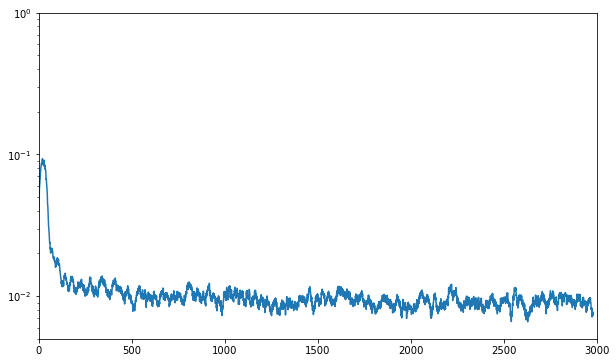

In [11]:
import numpy as np
D = 100
step_size = 0.2
reg_coeff = 0.03
threshold = 0.5

def KRLS(u,d,kernel,threshold,alpha_0=np.matrix(0).reshape(1,1),beta=1.0):

    err = []
    m = 1
    dictionary = u[0].reshape(1,2)
    h = kernel.fun(u[0],dictionary).reshape(1,1)
    k = kernel.fun(u[0],u[0])
    K_inv = np.matrix(1/k)

    P = np.matrix(1)
#     alpha = np.array(d[0]/k).reshape(1,1)
    alpha = alpha_0
    err.append((d[0] - h.T @ alpha).item())
    for n in range(1, len(d)):
        u_n = u[n].reshape(1,2)
        k = kernel.fun(u_n,u_n)
        h = np.array([kernel.fun(u_n,dictionary[j]) for j in range(len(dictionary))]).T.reshape(m,1)
        a = K_inv @ h
        delta = (k - h.T @ a).item()
        err.append((d[n] - h.T @ alpha).item())
        if delta > threshold:
            dictionary = np.r_[dictionary, u_n]

            K_inv_num = np.c_[delta*K_inv + a @ a.T,-a]
            K_inv_den = np.c_[-a.T, 1]
            K_inv = np.r_[K_inv_num,K_inv_den]
            K_inv = K_inv/delta

            P_num = np.c_[P,np.zeros((m,1))]
            P_den = np.c_[np.zeros((m,1)).T, 1]
            P = np.r_[P_num,P_den]

            alpha = np.array(alpha - ((a * err[-1])/delta)).reshape(m,1)
            alpha = np.r_[alpha,[[err[-1]/delta]]]
            m = m + 1
        else:
            P_a = P @ a
            a_P_a = a.T @ P_a
            q_t = (P_a)/(beta + a_P_a)
            P = (P - ((P_a @ a.T @ P)/(beta + a_P_a)))/beta
            alpha = alpha + K_inv @ q_t * err[-1]

#     print('number of SVs',len(dictionary))
    return err,h,alpha
# Experiment
mse = np.zeros(num_data)
num_experiments = 25
for ii in tqdm(range(num_experiments)):
    u,d,d_true = generate_data(num_data)
#     sigma = 1/np.sqrt(2*kernel.sigma)
#     W = (1/sigma) * np.random.normal(loc=0, scale=sigma, size=(2,D))
#     b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
#     h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

#     startTime = time.time()
    err,_,_ = KRLS(u,d,kernel,threshold)
    mse = mse + (np.square((d_true - d) + err))/num_experiments

mse_smooth = np.convolve(mse,np.ones(20)/20,'valid')
plt.figure(figsize=(10, 6))
plt.semilogy(range(len(mse_smooth)),mse_smooth)
plt.ylim([0.005,1e0])
plt.xlim([0,3000])
plt.show()

-0.12411577643639983

In [48]:
def KRLS_RFF2(u,d,kernel,l,beta,D):

    err = np.array([])

    W = np.random.normal(loc=0, scale=2.25, size=(2,D))
    b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
    
    # Initalization
    P = np.eye(D)/l
    alpha = np.zeros((D,1))
    for n in range(1, len(d)):
        u_n = u[n].reshape(1,2)
        d_n = d[n]
        k = kernel(u_n,u_n)
        h = np.sqrt(2/D) * np.cos(W.T @ u_n + b)
        a = K_inv @ h
        delta = (k - h.T @ a).item()
        err = np.append(err,d_n - h.T @ alpha)
        if delta > threshold:
            dictionary = np.r_[dictionary, u_n]

            K_inv_num = np.c_[delta*K_inv + a @ a.T,-a]
            K_inv_den = np.c_[-a.T, 1]
            K_inv = np.r_[K_inv_num,K_inv_den]
            K_inv = K_inv/delta

            P_num = np.c_[P,np.zeros((m,1))]
            P_den = np.c_[np.zeros((m,1)).T, 1]
            P = np.r_[P_num,P_den]

            alpha = np.array(alpha - ((a * err[-1])/delta)).reshape(m,1)
            alpha = np.r_[alpha,[[err[-1]/delta]]]
            m = m + 1


        q_t = (P @ a)/(1 + a.T @ P @ a)
        P = P - ((P @ a @ a.T @ P)/(1 + a.T @ P @ a))

        alpha = alpha + K_inv @ q_t * err[-1]

#     print('number of SVs',len(dictionary))
    return err

# Experiment
mse = np.zeros(num_data)

for i in tqdm(range(num_experiments)):
#     print('experiment',i+1)
    u,d,d_true = generate_data(num_data)
    startTime = time.time()
    err = KRLS_RFF2(u,d,kernel,0.1,1,20)
#     mse = mse + (((d_true - d) + err)**2)/num_experiments

# mse_smooth = np.convolve(mse,np.ones(20)/20,'valid')

array([0.0033299 , 0.03037374, 0.00868982, ...,        nan,        nan,
              nan])